## NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [1]:
import sys
# !{sys.executable} -m pip install gdown h5py

In [3]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import explained_variance_score, r2_score

url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
# gdown.download(url, output, quiet=False, fuzzy=True)

### Load the data

In [4]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [5]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

print(stimulus_train.shape)
print(spikes_train.shape)

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224
(2592, 3, 224, 224)
(2592, 168)


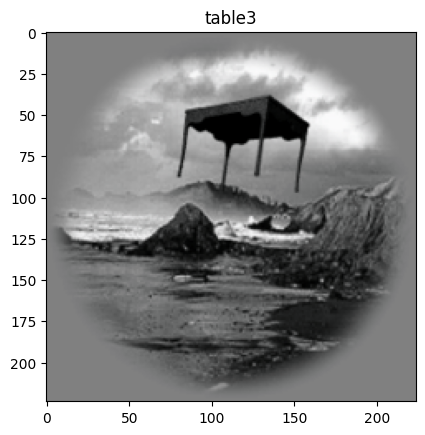

In [6]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

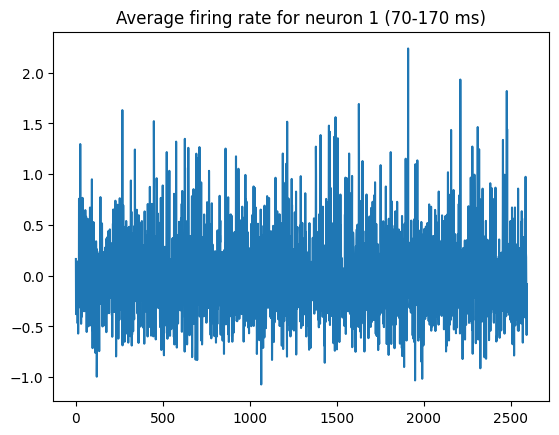

In [7]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

### Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [7]:
#### Reshape the input
stimulus_train_reshape = stimulus_train.reshape(n_stimulus, n_channels * img_size * img_size)
stimulus_val_reshape = stimulus_val.reshape(stimulus_val.shape[0], n_channels * img_size * img_size)
stimulus_test_reshape = stimulus_test.reshape(stimulus_test.shape[0], n_channels * img_size * img_size)

In [8]:
# Linear regression on train
linear_regression = LinearRegression()
# linear_regression.fit(stimulus_train_reshape, spikes_train)
# load the model simple_linear_non_reg.sav
import pickle
filename = 'simple_linear_non_reg.sav'
loaded_model = pickle.load(open(filename, 'rb'))
linear_regression = loaded_model
predictions_train = linear_regression.predict(stimulus_train_reshape)
predictions_val = linear_regression.predict(stimulus_val_reshape)




Linear regression on train
Train explained variance score: 0.9999999528129896
Train r2 score: 0.9999999656425878
Validation explained variance score: -1.1615340191693533
Validation r2 score: -1.1712278580022808


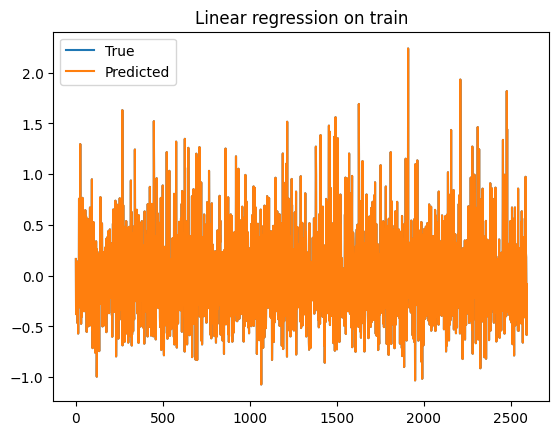

In [9]:
# Inspect
print('Linear regression on train')
print('Train explained variance score: {}'.format(explained_variance_score(spikes_train, predictions_train)))
print('Train r2 score: {}'.format(r2_score(spikes_train, predictions_train)))
print('Validation explained variance score: {}'.format(explained_variance_score(spikes_val, predictions_val)))
print('Validation r2 score: {}'.format(r2_score(spikes_val, predictions_val)))

plt.figure()
plt.title('Linear regression on train')
plt.plot(spikes_train[:, neuron_idx], label='True')
plt.plot(predictions_train[:, neuron_idx], label='Predicted')
plt.legend()
plt.show()

In [ ]:
import pickle
filename = 'simple_linear_non_reg.sav'
pickle.dump(linear_regression, open(filename, 'wb'))

##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

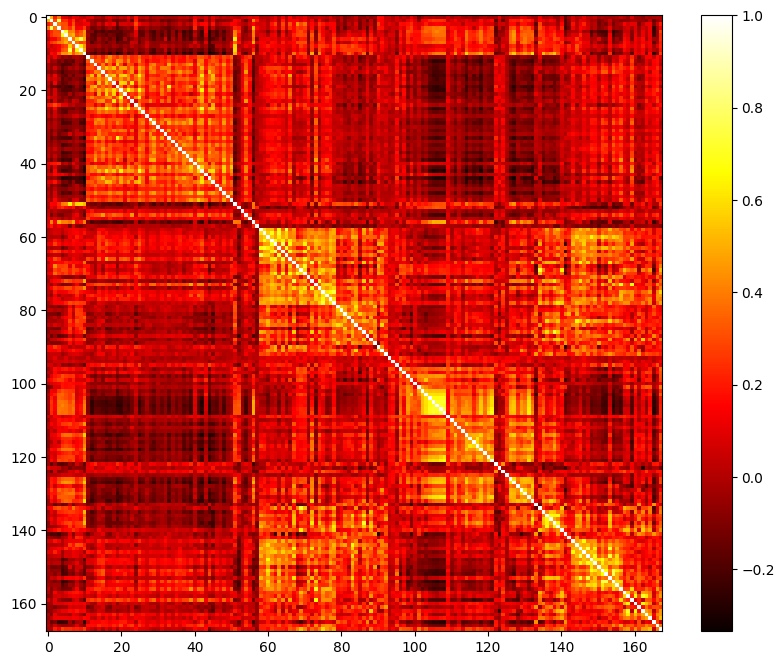

In [10]:
#### Here your code\
# correlate the neurons of the model with each other and plot the correlation matrix
# compute the correlation matrix
correlation_matrix = np.corrcoef(predictions_train.T)
# plot the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')
# show the correlation matrix numberline for the colors
plt.colorbar()



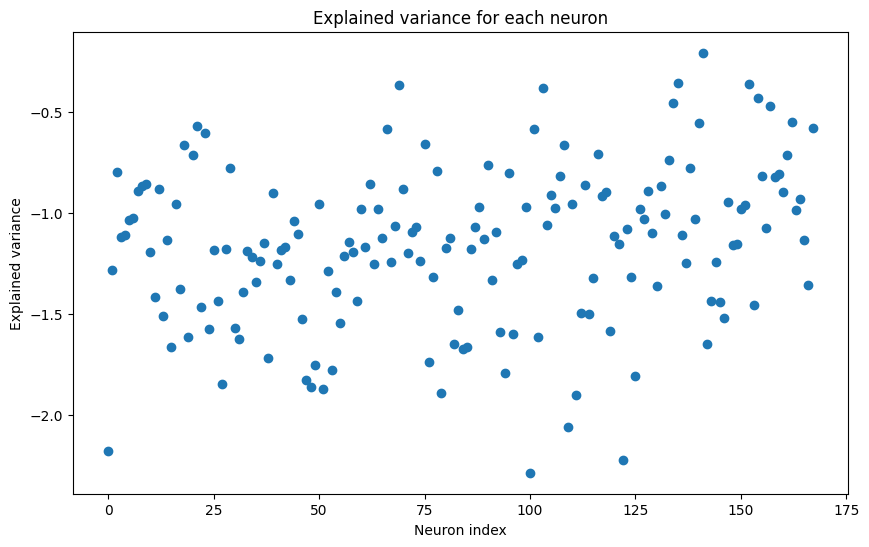

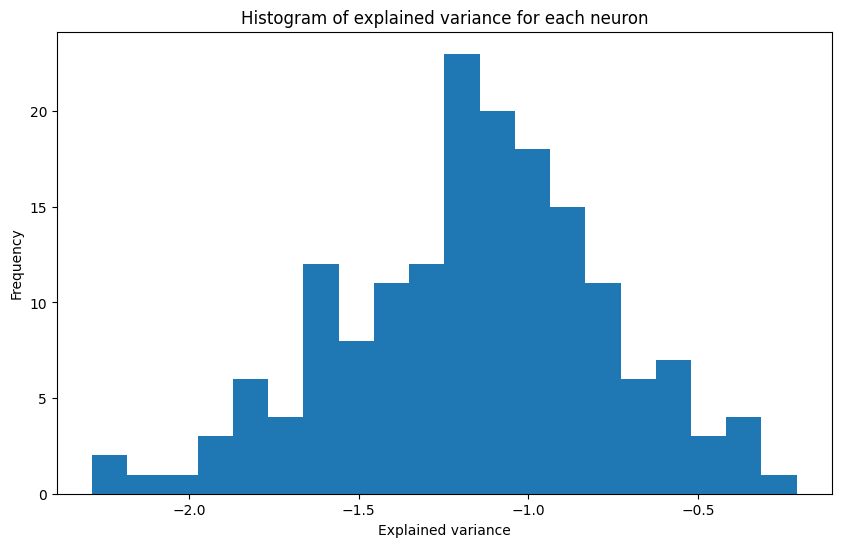

In [11]:
# # print the explained variance for each neuron
# print('Explained variance for each neuron:')
# for i in range(n_neurons):
#     print('Neuron {}: {}'.format(i, explained_variance_score(spikes_train[:, i], predictions_train[:, i])))
    
# plot the explained variance for each neuron
plt.figure(figsize=(10, 6))
plt.scatter(range(n_neurons), [explained_variance_score(spikes_val[:, i], predictions_val[:, i]) for i in range(n_neurons)])
plt.xlabel('Neuron index')
plt.ylabel('Explained variance')
plt.title('Explained variance for each neuron')
plt.show()

# plot the histogram to bin the explained variance
plt.figure(figsize=(10, 6))
plt.hist([explained_variance_score(spikes_val[:, i], predictions_val[:, i]) for i in range(n_neurons)], bins=20)
plt.xlabel('Explained variance')
plt.ylabel('Frequency')
plt.title('Histogram of explained variance for each neuron')
plt.show()


##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [13]:
#### Here your code
# Apply PCA to the training data to reduce dimensionality of every image down to 1000 components
pca = PCA(n_components=1000)
pca.fit(stimulus_train_reshape)
# Transform the training, validation and test data
stimulus_train_pca = pca.transform(stimulus_train_reshape)
stimulus_val_pca = pca.transform(stimulus_val_reshape)
stimulus_test_pca = pca.transform(stimulus_test_reshape)
# Check the shape of the PCA transformed data
print(stimulus_train_pca.shape)
print(stimulus_val_pca.shape)

(2592, 1000)
(288, 1000)


In [ ]:
# apply normal logistic regression to the PCA transformed data
linear_regression_pca = LinearRegression()
linear_regression_pca.fit(stimulus_train_pca, spikes_train)
predictions_train_pca = linear_regression_pca.predict(stimulus_train_pca)
predictions_val_pca = linear_regression_pca.predict(stimulus_val_pca)
# Inspect
print('Linear regression on PCA train')
print('Train explained variance score: {}'.format(explained_variance_score(spikes_train, predictions_train_pca)))
print('Train r2 score: {}'.format(r2_score(spikes_train, predictions_train_pca)))
print('Validation explained variance score: {}'.format(explained_variance_score(spikes_val, predictions_val_pca)))
print('Validation r2 score: {}'.format(r2_score(spikes_val, predictions_val_pca)))

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

Best alpha value: 20.0
Ridge regression on PCA train
Train explained variance score: 0.46231586805411745
Train r2 score: 0.4623158767676519
Validation explained variance score: -0.09222942235923949
Validation r2 score: -0.09635453239068956
Alpha: 0, Explained variance: -0.09263434012730916
Alpha: 1, Explained variance: -0.09261406319481987
Alpha: 5, Explained variance: -0.09253296433460145
Alpha: 10, Explained variance: -0.09243166091896239
Alpha: 20, Explained variance: -0.09222942235923949


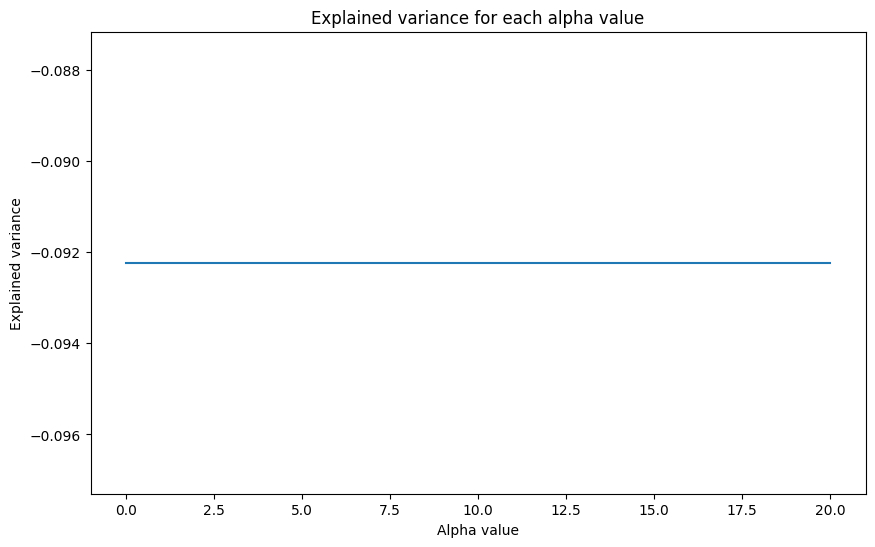

In [15]:
#### Here your code
# Perform ridge regression on the PCA transformed training data using cross-validation to find the best alpha value
ridge = Ridge()
alphas = np.linspace(0, 20, 100)
param_grid = {'alpha': alphas}

# apply a grid search to find the best alpha value
grid_search = GridSearchCV(ridge, param_grid, cv=5)
grid_search.fit(stimulus_train_pca, spikes_train)

best_alpha = grid_search.best_params_['alpha']
print('Best alpha value: {}'.format(best_alpha))
# apply ridge regression with the best alpha value
ridge = Ridge(alpha=best_alpha)
ridge.fit(stimulus_train_pca, spikes_train)
predictions_train_ridge = ridge.predict(stimulus_train_pca)
predictions_val_ridge = ridge.predict(stimulus_val_pca)

# Inspect
print('Ridge regression on PCA train')
print('Train explained variance score: {}'.format(explained_variance_score(spikes_train, predictions_train_ridge)))
print('Train r2 score: {}'.format(r2_score(spikes_train, predictions_train_ridge)))
print('Validation explained variance score: {}'.format(explained_variance_score(spikes_val, predictions_val_ridge)))
print('Validation r2 score: {}'.format(r2_score(spikes_val, predictions_val_ridge)))

# print the value of the explained variance when using alpha = 0, 1, 5, 10, and 20
alphas = [0, 1, 5, 10, 20]
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(stimulus_train_pca, spikes_train)
    predictions_val_ridge = ridge.predict(stimulus_val_pca)
    print('Alpha: {}, Explained variance: {}'.format(alpha, explained_variance_score(spikes_val, predictions_val_ridge)))

# plot the explained variance for each alpha value
plt.figure(figsize=(10, 6))
plt.plot(alphas, [explained_variance_score(spikes_val, ridge.predict(stimulus_val_pca)) for alpha in alphas])
plt.xlabel('Alpha value')
plt.ylabel('Explained variance')
plt.title('Explained variance for each alpha value')
plt.show()




We can see that the explained variance does not actually increase as we increase alpha in ridge regression. This is actually expected, since individual pixels in an image do not necessitate being able to understand the entire image. Especially in IT neurons, which fire based on the actual image and require a holistic understanding of the image and context. Even when applying PCA, we are still effectively getting pieces of the image that represent the largest variance, rather than the object itself.

What might solve this is a task driven modeling approach, where we could model our network as the brain does at the level of the IT, rather than at a retinal level as is done above, with individual pixels being used for classification.

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [8]:
# download keras 
!{sys.executable} -m pip install keras tensorflow

In [9]:

# - Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
# - Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
# - Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
# - Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?



In [9]:
#### Here your code
# Get a pretrained resnet50 model
import keras
from keras.applications import ResNet50
from keras.models import Model

from keras import backend as K
K.clear_session()

# - Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']


# Load model
pre_trained_model = ResNet50(weights='imagenet', include_top=True, input_shape=(img_size, img_size, 3))

# Map their conceptual layer names to Keras layer names
layer_map = {
    'conv1': 'conv1_conv',
    'layer1': 'conv2_block3_out',
    'layer2': 'conv3_block4_out',
    'layer3': 'conv4_block6_out',
    'layer4': 'conv5_block3_out',
    'avgpool': 'avg_pool'
}
activation_model = Model(inputs=pre_trained_model.input, 
                         outputs=[pre_trained_model.get_layer(name).output for name in layer_map.values()])



2025-04-19 13:31:05.547990: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-19 13:31:05.688869: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-19 13:31:07.822863: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-19 13:31:08.404657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745062269.320586 3354877 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745062269.53

In [ ]:
from keras.applications.resnet50 import preprocess_input


X_train_prep = preprocess_input(stimulus_train)
X_test_prep = preprocess_input(stimulus_val)

X_train_prep = np.reshape(X_train_prep, (X_train_prep.shape[0], img_size, img_size, n_channels))
X_test_prep = np.reshape(X_test_prep, (X_test_prep.shape[0], img_size, img_size, n_channels))




In [11]:
from sklearn.preprocessing import StandardScaler
import joblib

layer_pca_models = {}
train_pca_activations = {}

n_components = 1000  # Number of PCA components
for i, (logical_name, keras_name) in enumerate(layer_map.items()):
    print(f"Processing layer: {logical_name}")
    
    # Extract activations
    layer_train_acts = activation_model.predict(X_train_prep)[i]
    flat_train = layer_train_acts.reshape(layer_train_acts.shape[0], -1)


    # Compute PCA
    pca = PCA(n_components=n_components)
    train_pca = pca.fit_transform(flat_train)

    # Save PCA & scaler
    joblib.dump(pca, f'pca_{logical_name}.pkl')

    # Store projected features
    train_pca_activations[logical_name] = train_pca


Processing layer: conv1
81/81 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step
Processing layer: layer1
81/81 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step
Processing layer: layer2
81/81 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step
Processing layer: layer3
81/81 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step
Processing layer: layer4
81/81 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step
Processing layer: avgpool
81/81 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step


#### For layer 1, (conv1), load the PCA and test

In [14]:
from sklearn.linear_model import Ridge
from sklearn.metrics import explained_variance_score

layer_name = 'conv1'
layer_index = list(layer_map.keys()).index(layer_name)

# 1. Extract test activations
layer_test_acts = activation_model.predict(X_test_prep, batch_size=32)[layer_index]
layer_train_acts = activation_model.predict(X_train_prep, batch_size=32)[layer_index]
layer_val_acts = activation_model.predict(X_test_prep, batch_size=32)[layer_index]
flat_test = layer_test_acts.reshape(layer_test_acts.shape[0], -1)
flat_train = layer_train_acts.reshape(layer_train_acts.shape[0], -1)


9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step


In [15]:
import joblib
# 2. Load PCA and transform test data
pca = joblib.load(f'pca_{layer_name}.pkl')
test_pca = pca.transform(flat_test)
train_pca = pca.transform(flat_train)
print(test_pca.shape)
print(train_pca.shape)


(288, 1000)
(2592, 1000)


In [22]:
print(spikes_train.shape)
print(train_pca.shape)

(2592, 168)
(2592, 1000)


In [31]:
# 3. Train regression model on train_pca

alphas = [0,0.1,0.5,1,5,10,20]
best_alpha = 0
explained_variance_score_current = -1000
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(train_pca, spikes_train)
    predictions_val_ridge = ridge.predict(test_pca)
    predictions_train_ridge = ridge.predict(train_pca)
    print('Alpha: {}, Explained variance: {}'.format(alpha, explained_variance_score(predictions_train_ridge, spikes_train)))
    print('Alpha: {}, Explained variance: {}'.format(alpha, explained_variance_score(predictions_val_ridge, spikes_val)))
    if explained_variance_score(predictions_val_ridge, spikes_val) > explained_variance_score_current:
        explained_variance_score_current = explained_variance_score(predictions_val_ridge, spikes_val)
        best_alpha = alpha




Alpha: 0, Explained variance: -0.19661100208759308
Alpha: 0, Explained variance: -1.8206506967544556
Alpha: 0.1, Explained variance: -0.19661128520965576
Alpha: 0.1, Explained variance: -1.8206510543823242
Alpha: 0.5, Explained variance: -0.19661276042461395
Alpha: 0.5, Explained variance: -1.8206537961959839
Alpha: 1, Explained variance: -0.1966145634651184
Alpha: 1, Explained variance: -1.8206572532653809
Alpha: 5, Explained variance: -0.19662874937057495
Alpha: 5, Explained variance: -1.8206838369369507
Alpha: 10, Explained variance: -0.19664660096168518
Alpha: 10, Explained variance: -1.8207170963287354
Alpha: 20, Explained variance: -0.19668211042881012
Alpha: 20, Explained variance: -1.8207833766937256


In [32]:

ridge = Ridge(alpha=best_alpha)
ridge.fit(train_pca, spikes_train)

# 5. Predict on test data using best alpha
preds = ridge.predict(test_pca)




In [ ]:
# 6. Evaluate
ev = explained_variance_score(spikes_val, preds, multioutput='raw_values')
mean_ev = ev.mean()

print(f"{layer_name} → Mean Explained Variance: {mean_ev:.4f}")



conv1 → Mean Explained Variance: -0.1631


Processing layer: conv1
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
Alpha: 0, Explained variance: -0.19661100208759308
Alpha: 0, Explained variance: -1.8206506967544556
Alpha: 0.1, Explained variance: -0.19661128520965576
Alpha: 0.1, Explained variance: -1.8206510543823242
Alpha: 0.5, Explained variance: -0.19661276042461395
Alpha: 0.5, Explained variance: -1.8206537961959839
Alpha: 1, Explained variance: -0.1966145634651184
Alpha: 1, Explained variance: -1.8206572532653809
Alpha: 5, Explained variance: -0.19662874937057495
Alpha: 5, Explained variance: -1.8206838369369507
Alpha: 10, Explained variance: -0.19664660096168518
Alpha: 10, Explained variance: -1.8207170963287354
Alpha: 20, Explained variance: -0.19668211042881012
Alpha: 20, Explained variance: -1.8207833766937256
conv1 → Mean Explained Variance: -0.1631


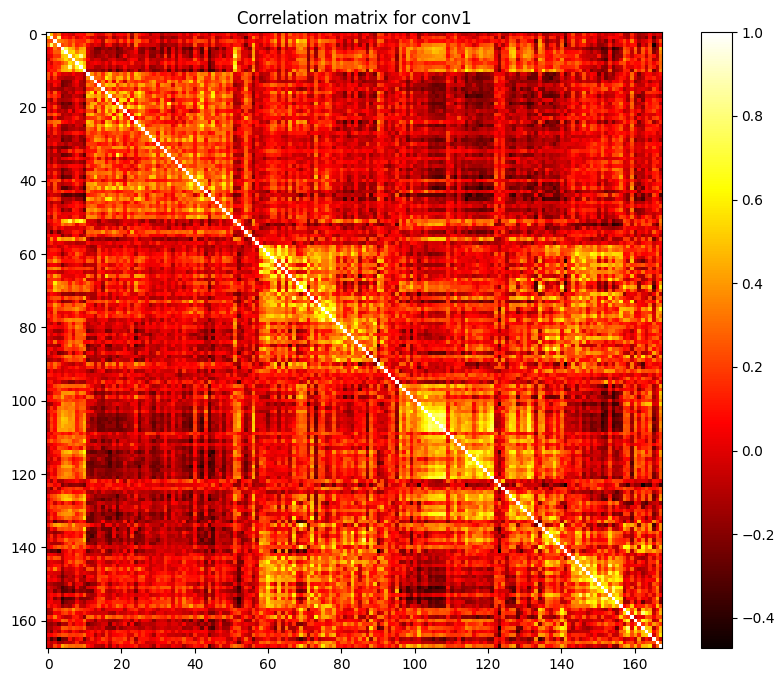

Processing layer: layer1
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
Alpha: 0, Explained variance: 0.27042824029922485
Alpha: 0, Explained variance: -0.879613995552063
Alpha: 0.1, Explained variance: 0.2704242467880249
Alpha: 0.1, Explained variance: -0.8796201348304749
Alpha: 0.5, Explained variance: 0.27040812373161316
Alpha: 0.5, Explained variance: -0.8796446919441223
Alpha: 1, Explained variance: 0.27038806676864624
Alpha: 1, Explained variance: -0.879675030708313
Alpha: 5, Explained variance: 0.2702268064022064
Alpha: 5, Explained variance: -0.8799187541007996
Alpha: 10, Explained variance: 0.270025372505188
Alpha: 10, Explained variance: -0.8802233338356018
Alpha: 20, Explained variance: 0.2696223855018616
Alpha: 20, Explained variance: -0.8808321952819824
layer1 → Mean Explained Variance: 0.1551


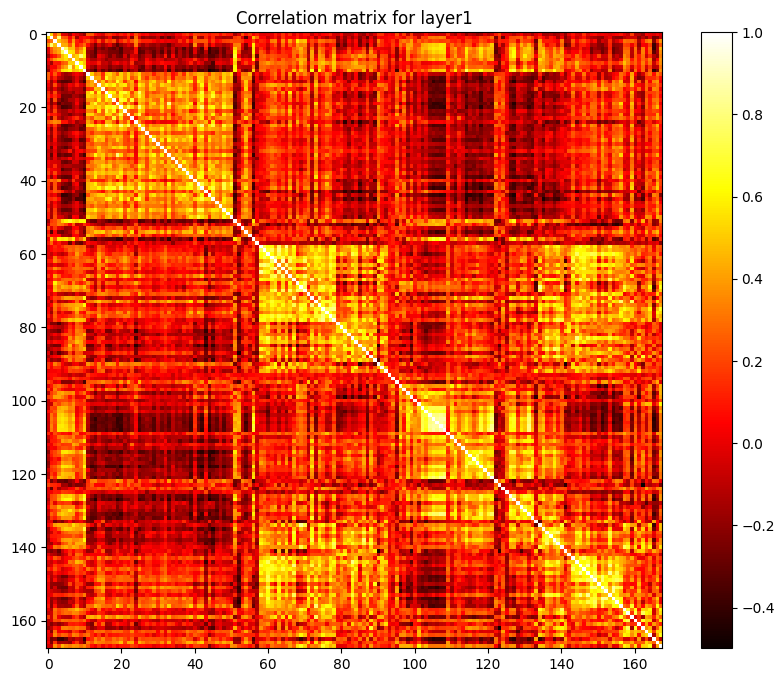

Processing layer: layer2
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
Alpha: 0, Explained variance: 0.3391662836074829
Alpha: 0, Explained variance: -0.735184907913208
Alpha: 0.1, Explained variance: 0.33916276693344116
Alpha: 0.1, Explained variance: -0.7351895570755005
Alpha: 0.5, Explained variance: 0.3391486704349518
Alpha: 0.5, Explained variance: -0.7352079749107361
Alpha: 1, Explained variance: 0.3391309678554535
Alpha: 1, Explained variance: -0.7352310419082642
Alpha: 5, Explained variance: 0.33898934721946716
Alpha: 5, Explained variance: -0.735414445400238
Alpha: 10, Explained variance: 0.33881232142448425
Alpha: 10, Explained variance: -0.7356435656547546
Alpha: 20, Explained variance: 0.33845824003219604
Alpha: 20, Explained variance: -0.7361018061637878
layer2 → Mean Explained Variance: 0.2445


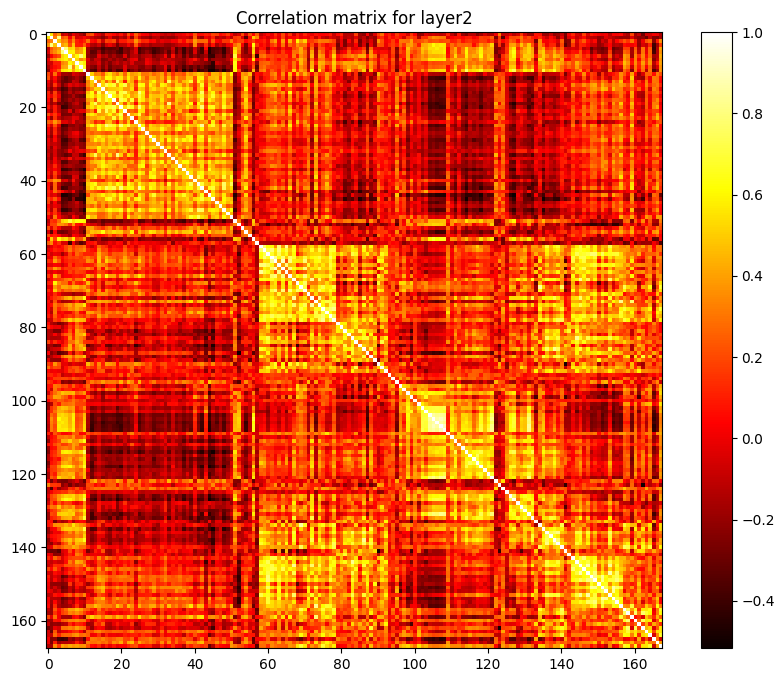

Processing layer: layer3
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
Alpha: 0, Explained variance: 0.2863101363182068
Alpha: 0, Explained variance: -0.8761346936225891
Alpha: 0.1, Explained variance: 0.2862979769706726
Alpha: 0.1, Explained variance: -0.8761500120162964
Alpha: 0.5, Explained variance: 0.2862497568130493
Alpha: 0.5, Explained variance: -0.8762118220329285
Alpha: 1, Explained variance: 0.2861894369125366
Alpha: 1, Explained variance: -0.8762888312339783
Alpha: 5, Explained variance: 0.28570711612701416
Alpha: 5, Explained variance: -0.8769049644470215
Alpha: 10, Explained variance: 0.2851036787033081
Alpha: 10, Explained variance: -0.8776746392250061
Alpha: 20, Explained variance: 0.28389716148376465
Alpha: 20, Explained variance: -0.8792119026184082
layer3 → Mean Explained Variance: 0.2132


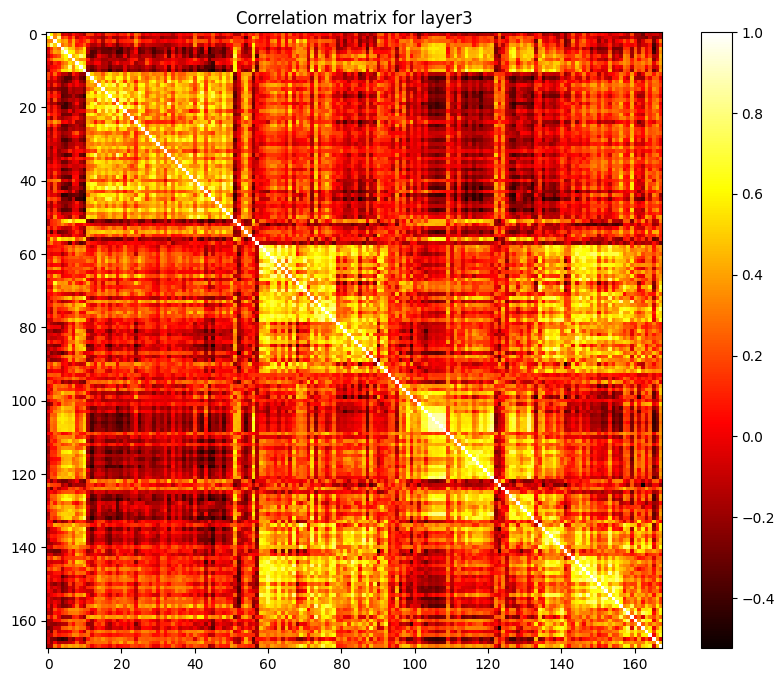

Processing layer: layer4
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
Alpha: 0, Explained variance: 0.21987642347812653
Alpha: 0, Explained variance: -0.9739561676979065
Alpha: 0.1, Explained variance: 0.219856396317482
Alpha: 0.1, Explained variance: -0.9739834070205688
Alpha: 0.5, Explained variance: 0.21977674961090088
Alpha: 0.5, Explained variance: -0.9740921854972839
Alpha: 1, Explained variance: 0.21967697143554688
Alpha: 1, Explained variance: -0.9742286205291748
Alpha: 5, Explained variance: 0.21887987852096558
Alpha: 5, Explained variance: -0.9753182530403137
Alpha: 10, Explained variance: 0.2178833782672882
Alpha: 10, Explained variance: -0.9766783714294434
Alpha: 20, Explained variance: 0.215889573097229
Alpha: 20, Explained variance: -0.9793931841850281
layer4 → Mean Explained Variance: 0.1512


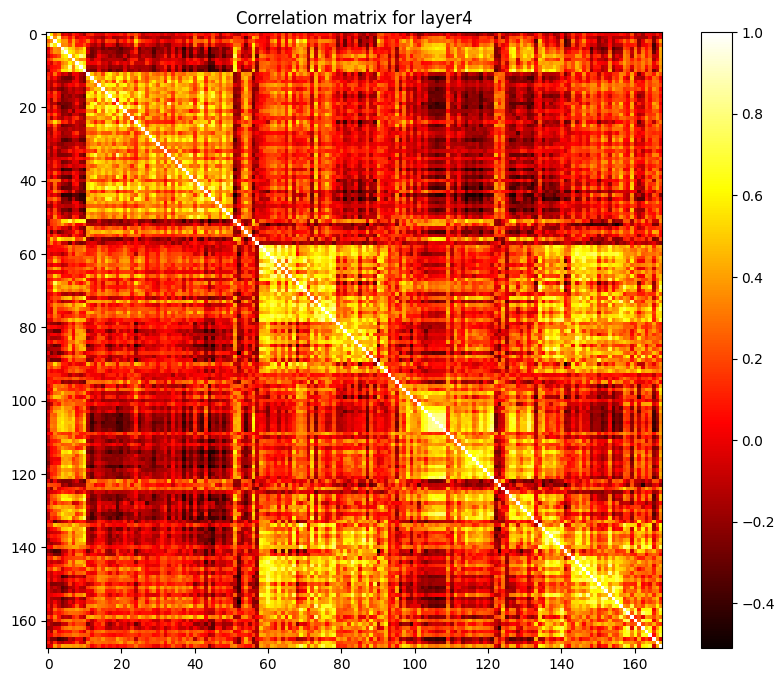

Processing layer: avgpool
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
Alpha: 0, Explained variance: 0.10385793447494507
Alpha: 0, Explained variance: -0.6027549505233765
Alpha: 0.1, Explained variance: 0.047861531376838684
Alpha: 0.1, Explained variance: -0.6764906644821167
Alpha: 0.5, Explained variance: -0.13668935000896454
Alpha: 0.5, Explained variance: -0.9003672003746033
Alpha: 1, Explained variance: -0.31353673338890076
Alpha: 1, Explained variance: -1.0979385375976562
Alpha: 5, Explained variance: -1.0972727537155151
Alpha: 5, Explained variance: -1.8759307861328125
Alpha: 10, Explained variance: -1.642223596572876
Alpha: 10, Explained variance: -2.3733019828796387
Alpha: 20, Explained variance: -2.3449196815490723
Alpha: 20, Explained variance: -3.0005061626434326
avgpool → Mean Explained Variance: -0.2360


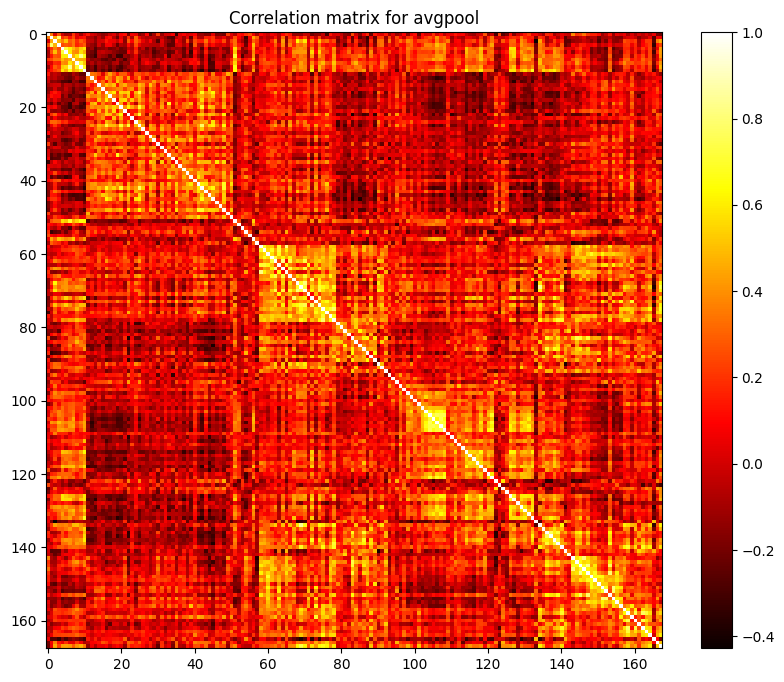

In [34]:
# loop over the rest of the layers
layer_pca_models = {}

for layer_name in layer_map.keys():

    print(f"Processing layer: {layer_name}")
    layer_index = list(layer_map.keys()).index(layer_name)

    # 1. Extract test activations
    layer_test_acts = activation_model.predict(X_test_prep, batch_size=32)[layer_index]
    layer_train_acts = activation_model.predict(X_train_prep, batch_size=32)[layer_index]
    layer_val_acts = activation_model.predict(X_test_prep, batch_size=32)[layer_index]
    flat_test = layer_test_acts.reshape(layer_test_acts.shape[0], -1)
    flat_train = layer_train_acts.reshape(layer_train_acts.shape[0], -1)

    pca = joblib.load(f'pca_{layer_name}.pkl')
    test_pca = pca.transform(flat_test)
    train_pca = pca.transform(flat_train)
    alphas = [0,0.1,0.5,1,5,10,20]
    best_alpha = 0
    explained_variance_score_current = -1000
    for alpha in alphas:
        ridge = Ridge(alpha=alpha)
        ridge.fit(train_pca, spikes_train)
        predictions_val_ridge = ridge.predict(test_pca)
        predictions_train_ridge = ridge.predict(train_pca)
        print('Alpha: {}, Explained variance: {}'.format(alpha, explained_variance_score(predictions_train_ridge, spikes_train)))
        print('Alpha: {}, Explained variance: {}'.format(alpha, explained_variance_score(predictions_val_ridge, spikes_val)))
        if explained_variance_score(predictions_val_ridge, spikes_val) > explained_variance_score_current:
            explained_variance_score_current = explained_variance_score(predictions_val_ridge, spikes_val)
            best_alpha = alpha

        
        ridge = Ridge(alpha=best_alpha)
        ridge.fit(train_pca, spikes_train)

    # 5. Predict on test data using best alpha
    preds = ridge.predict(test_pca)

    ev = explained_variance_score(spikes_val, preds, multioutput='raw_values')
    mean_ev = ev.mean()

    print(f"{layer_name} → Mean Explained Variance: {mean_ev:.4f}")

    # store the explained variance for each layer in a dictionary
    layer_pca_models[layer_name] = {
        'model': ridge,
        'explained_variance': mean_ev
    }

    # chceck the correlation metrics also of the predictions
    correlation_matrix = np.corrcoef(preds.T)
    # plot the correlation matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')
    # show the correlation matrix numberline for the colors
    plt.colorbar()
    plt.title(f'Correlation matrix for {layer_name}')
    plt.show()

In [ ]:
# - Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?

In [ ]:
# - Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?


In [ ]:
# - Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?